In [1]:
#IMPORTS
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
#MODIFIER DOMAIN VARIABLES

def mod_func_A(x):
    return x**2

def mod_func_B(x):
    return x*2/3

def rescaler(old_list, new_min, new_max):
    new_values=[]
    for old_value in old_list:
        new_values.append((((old_value - min(old_list)) * (new_max - new_min)) / (max(old_list) - min(old_list)))+ new_min)

    return new_values

# datapoints domain (min-max), min_mod_increment, max_mod_increment 
mdv={"domain_min_range":1, "domain_max_range":100, "modifier_incremental_unit":3, "modifier_data_point":10}
#mdv["modifier_data_point"] = 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def modifier_controller(interval_list=[(mdv["domain_min_range"], mdv["domain_max_range"])], selected_mod_function=mod_func_A, do_plot=False):
    # Function to control modifiers given the input and the selected modifier function. Option to plot or not. 
    
    print("\nModifier controller...")
    print('  * Interval: ',interval_list)
    all_interval_mod = []
    
    # Check if it's possible to generate more data points
    if mdv["modifier_data_point"] < mdv["modifier_incremental_unit"]:
        return False  # Exit the function if not possible
    
    for i in range(len(interval_list)):
        interval_min_range = interval_list[i][0]
        interval_max_range = interval_list[i][1]
        
        # Generate data points (incremental ticks and function modified x values) within the specified interval
        mod_ticks = np.arange(interval_min_range, interval_max_range, mdv["modifier_data_point"])
        mod_x = selected_mod_function(mod_ticks)
        
        # Normalize the function outputs to fit within the interval range
        mod_x = rescaler(mod_x, new_max=interval_max_range, new_min=interval_min_range)
        all_interval_mod.append(mod_x)
    
    # update the mdv to decrease the interdatapoint distance for the next itteration
    mdv["modifier_data_point"] = mdv["modifier_data_point"] - mdv["modifier_incremental_unit"]
    
    if do_plot == True:
        # Plot the generated data points
        for mod_x in all_interval_mod:
            plt.scatter(mod_x, np.ones(np.shape(mod_x)))
            plt.show()
    
    print('  * Mod_x:   ',all_interval_mod)

    return all_interval_mod


In [4]:
#SIMULATOR - data substitution in Sim function
def sim_func_A(x):
    noise = np.random.normal(-10000,10000,len(x))
    return x**3-x**2+noise

def sim_func_B(x):
    return x*2/3

def simulator(mod_x, selected_function=sim_func_A):
    print("\nSimulator...")
    all_interval_sim =[]
    if mod_x == False: 
        return False # possible itterations have ended
    else:
        for i in range(len(mod_x)):
            simulated_y = selected_function(np.array(mod_x[i]))
            all_interval_sim.append(list(simulated_y))
    print('  * Sim_y:   ',all_interval_sim)
    return all_interval_sim


## Part TWO
modifier and simulator working in dynamic way, with hardcoded ranges
* next step, extract the ranges 



In [9]:
# DRAFT TEMP FUNCTIONS that will be in validator once they work as intended
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PolynomialFeatures

def get_range(x_values,outliers,delta=0.7):
    x_values = np.array(x_values)
    relative_max = x_values[-1]
    relative_min = x_values[0]
    
    # Calculate ranges of outliers
    outlier_ranges = []

    current_range = [outliers[0]]
    print('current range: ',current_range)

    for i in range(1, len(outliers)):
        x_outlier_ranges = []

        if outliers[i] == outliers[i-1] + 1:
            current_range.append(outliers[i])
        else:
            
            outlier_ranges.append(current_range)
            current_range = [outliers[i]]

    # Add the last range
    outlier_ranges.append(current_range)
    print(outlier_ranges)
    # Get x value ranges for each outlier range
    x_range_max=relative_max
    x_range_min = relative_min
    for outlier_range in outlier_ranges:
        print('\noutlier_range ',outlier_range)
        if np.max(outlier_range)<(np.shape(x_values)[0]-1) and np.min(outlier_range)>0: 
            delta_low=delta*(x_values[np.min(outlier_range)] - x_values[np.min(outlier_range)-1])
            delta_high=delta*np.abs(x_values[np.max(outlier_range)] - x_values[np.max(outlier_range)+1])
            x_range_min = np.min(x_values[outlier_range])-delta_low
            x_range_max = np.max(x_values[outlier_range])+delta_high
            print('I am withing the min max')
        elif x_range_max>relative_max or np.max(outlier_range)==(np.shape(x_values)[0]-1):
            print('I am at max')
            delta_low=delta*(x_values[np.min(outlier_range)] - x_values[np.min(outlier_range)-1])
            x_range_min = np.min(x_values[outlier_range])-delta_low
            x_range_max=relative_max
        elif x_range_min<relative_min or np.min(outlier_range)==0:
            print('I am at min')
            delta_high=delta*np.abs(x_values[np.max(outlier_range)] - x_values[np.max(outlier_range)+1])
            x_range_max = np.max(x_values[outlier_range])+delta_high
            x_range_min = relative_min
        x_outlier_ranges.append((x_range_min, x_range_max))


    print("Ranges of outlier x values:")
    for i, x_range in enumerate(x_outlier_ranges):
        print(f"Outlier Range {i+1}: {x_range[0]} to {x_range[1]}")
    
    return x_outlier_ranges



def curve_fit(mod_x,sim_y, threshold=3):
    # Example data
    # mod_x = [1.0, 2.4347826086956523, 6.260869565217392, 12.478260869565217, 21.08695652173913, 32.086956521739125, 45.47826086956522, 61.26086956521739, 79.43478260869566, 100.0]
    # sim_y = [-18785.46448566434, -22589.28977083527, -13875.22366018544, -8366.169916783167, -10461.393801292468, 5188.58062260236, 76235.86972207189, 197523.09425923007, 435446.98046035116, 1004675.2544642929]

    # Reshape the arrays to match HuberRegressor's expectations
    x_values = np.array(mod_x)
    y_values = np.array(sim_y)

    # Create polynomial features
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x_values.reshape(-1, 1))

    # Fit a polynomial model using HuberRegressor
    huber_regressor = HuberRegressor()
    huber_regressor.fit(x_poly, y_values)

    # Predict y values based on the fitted polynomial model
    predicted_y_values = huber_regressor.predict(x_poly)

    # Calculate residuals (differences between actual y and predicted y)
    residuals = y_values - predicted_y_values

    # Calculate the median absolute deviation (MAD) of the residuals
    median_absolute_deviation = np.median(np.abs(residuals))

    # Define a threshold for outliers (e.g., 3 times MAD)
    outlier_threshold = threshold * median_absolute_deviation

    # Identify outliers
    outliers = np.where(np.abs(residuals) > outlier_threshold)[0]

    # Identify points of good fit
    good_fit_points = np.where(np.abs(residuals) <= outlier_threshold)[0]

    print("Outlier indices:", outliers)
    print("Good fit indices:", good_fit_points)

    # Plot the original data and the fitted polynomial curve
    plt.scatter(x_values, y_values, label='Data points')
    plt.plot(x_values, predicted_y_values, color='red', label='Fitted polynomial')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Fitted Polynomial and Data Points')
    plt.show()
    return outliers, good_fit_points



Modifier controller...
  * Interval:  [(1, 100)]
  * Mod_x:    [[1.0, 2.4347826086956523, 6.260869565217392, 12.478260869565217, 21.08695652173913, 32.086956521739125, 45.47826086956522, 61.26086956521739, 79.43478260869566, 100.0]]

Simulator...
  * Sim_y:    [[-14142.337316890797, -22216.18785242596, -11825.156336170896, -5284.74510045384, -2662.8604858964063, 34507.81744425923, 86659.61545463411, 216792.22500091733, 484337.3165789996, 982602.386621334]]
shape of mod_x_list 10
shape of mod_x_list[0] (10,)
Outlier indices: [4 5 7 8 9]
Good fit indices: [0 1 2 3 6]


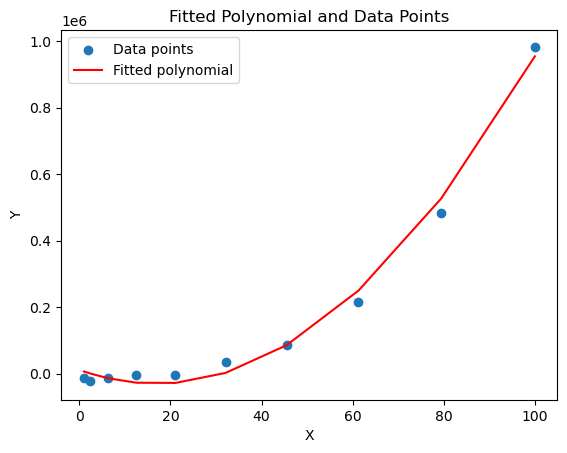

shape of mod_x_list 10
shape of mod_x_list[0] (10,)


IndexError: list index out of range

In [12]:
# PLACEHOLDER FOR THE MAIN FUNCTION V3 TEMP DRAFT
from Validator import Validator

# Instantiate mdv values
mdv={"domain_min_range":1, "domain_max_range":100, "modifier_incremental_unit":2, "modifier_data_point":10}
# Create an instance of the Validator Class
validate = Validator()
appendedvars=[]

mainfunc=True
# Initialize interval list
interval_lists=[(mdv["domain_min_range"], mdv["domain_max_range"])]
x=1


while mainfunc==True:
    # Run Modifier Controller Function
    mod_x_list = modifier_controller(interval_list=interval_lists,do_plot=False,selected_mod_function=mod_func_A)

    if mod_x_list == False:
        print('*   ITTERATIONS END HERE   *')
        break

    # Run Simulator Fuction
    # print('mod_list shape is: ',np.shmod_x_list))
    sim_y_list = simulator(mod_x_list,selected_function=sim_func_A)
    assert len(mod_x_list) == len(sim_y_list)
    # Get ranges of unfit points ( IF ANY )
    # ranges = validate.get_range(mod_x_list,sim_y_list)
    # mod_x_list = [1.0, 2.4347826086956523, 6.260869565217392, 12.478260869565217, 21.08695652173913, 32.086956521739125, 45.47826086956522, 61.26086956521739, 79.43478260869566, 100.0]
    # sim_y_list = [-18785.46448566434, -22589.28977083527, -13875.22366018544, -8366.169916783167, -10461.393801292468, 5188.58062260236, 76235.86972207189, 197523.09425923007, 435446.98046035116, 1004675.2544642929]
    for i in range(0,np.shape(mod_x_list)[1]): 
        print('shape of mod_x_list',np.shape(mod_x_list)[1])
        print('shape of mod_x_list[0]',np.shape(mod_x_list[0]))
        outlier,good_fit = curve_fit(mod_x_list[i],sim_y_list[i], threshold=1)

    ranges=get_range(mod_x_list,outlier,delta=0.7)
    print(outlier)

    interval_lists = ranges


# TODO: 
# Validator needs to work as a loop within itseft that accepts 3 different sets of points
# understand curve fitting
# Fix ranges



Modifier controller...
  * Interval:  [(1, 100)]


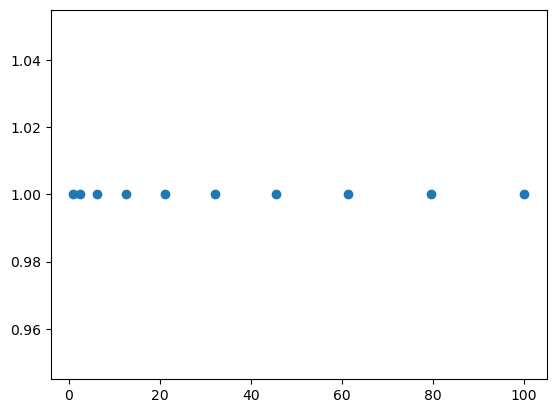

  * Mod_x:    [[1.0, 2.4347826086956523, 6.260869565217392, 12.478260869565217, 21.08695652173913, 32.086956521739125, 45.47826086956522, 61.26086956521739, 79.43478260869566, 100.0]]

Simulator...
  * Sim_y:    [[-21729.454659481613, -7229.173442454686, 9274.263979319281, -386.68844549005803, -13714.087070296833, 21322.18460965927, 101821.36846406086, 218349.57337130298, 496205.71132621233, 963998.4877206361]]

Modifier controller...
  * Interval:  [(0, 50), (70, 80)]


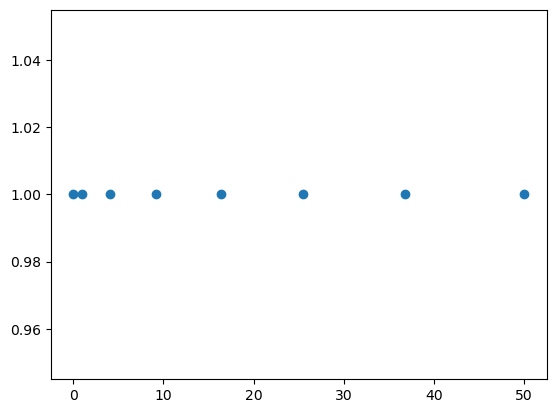

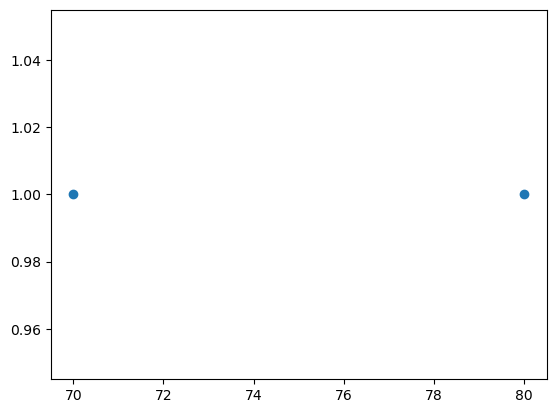

  * Mod_x:    [[0.0, 1.0204081632653061, 4.081632653061225, 9.183673469387756, 16.3265306122449, 25.510204081632654, 36.734693877551024, 50.0], [70.0, 80.0]]

Simulator...
  * Sim_y:    [[-7497.978923114657, -9617.284867536759, -8638.751837957921, -6240.854323299753, -3336.205798256601, -6628.437891524427, 55161.16049960586, 121518.97435707806], [334789.28641170356, 503760.51774300076]]

Modifier controller...
  * Interval:  [(30, 50), (70, 75)]


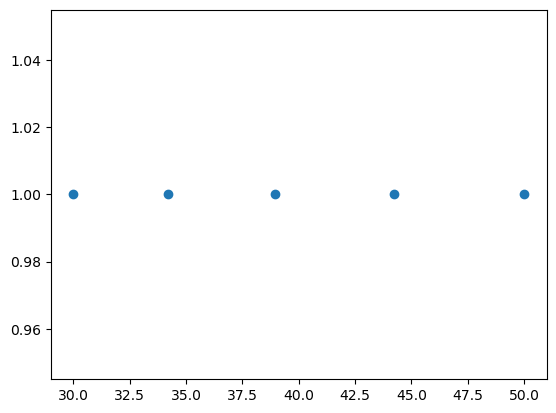

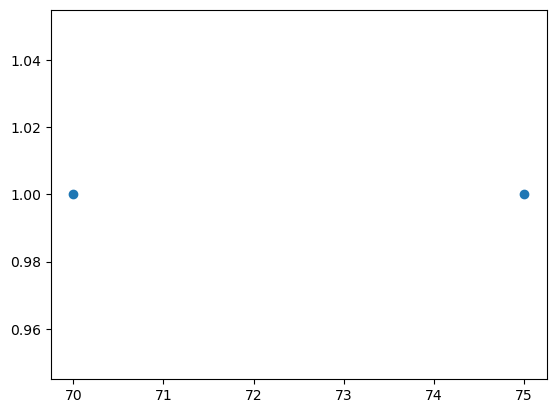

  * Mod_x:    [[30.0, 34.21052631578947, 38.94736842105263, 44.21052631578947, 50.0], [70.0, 75.0]]

Simulator...
  * Sim_y:    [[9953.23013060042, 27256.179811957874, 63936.16078927013, 72711.83745675083, 119564.5837735665], [323940.78795627545, 391589.51870208856]]
The END


In [8]:
# PLACEHOLDER FOR THE MAIN FUNCTION V2
from Validator import Validator

# Instantiate mdv values
mdv={"domain_min_range":1, "domain_max_range":100, "modifier_incremental_unit":3, "modifier_data_point":10}
# Create an instance of the Validator Class
validate = Validator()
appendedvars=[]

mainfunc=True
# Initialize interval list
interval_lists=[(mdv["domain_min_range"], mdv["domain_max_range"])]
x=1
while mainfunc==True:
    # Run Modifier Controller Function
    mod_x_list = modifier_controller(interval_list=interval_lists,do_plot=True,selected_mod_function=mod_func_A)
    # appendedvars.append(mod_x_list)
    if mod_x_list == False:
        print('*   ITTERATIONS END HERE   *')
        break

    # Run Simulator Fuction
    # for i in range(np.shape(mod_x_list)[0]):
    sim_y_list = simulator(mod_x_list,selected_function=sim_func_A)
    assert len(mod_x_list) == len(sim_y_list)
    # Get ranges of unfit points ( IF ANY )
    ranges = validate.get_unfitting_ranges(mod_x_list,sim_y_list)
    print('these are the ranges of validator\n',ranges)

    ## TODO: Replace for loops with Validator functions that return ranges [(),(),()] format
    if x == 1: 
        ranges = [(0,50),(70,80)]
    elif x == 2:
        ranges = [(30,50),(70,75)]
    elif x==3: 
        ranges = False
    x=x+1
    if mod_x_list == False or not ranges: 
        mainfunc=False
        print('The END')
    interval_lists = ranges


# TODO: 
# Validator needs to work as a loop within itseft that accepts 3 different sets of points
# understand curve fitting
# Fix ranges
